# 1. 준비
## (1) 패키지 import

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


## (2) 데이터 불러오기

In [4]:
d = pd.read_parquet('005930.parquet')

d

,timestamp,ticker,open,high,low,close,volume
0,20100104,005930,16060.0,16180.0,16000.0,16180.0,11963550.0
1,20100105,005930,16520.0,16580.0,16300.0,16440.0,27960950.0
2,20100106,005930,16580.0,16820.0,16520.0,16820.0,22987750.0
3,20100107,005930,16820.0,16820.0,16260.0,16260.0,22161850.0
4,20100108,005930,16400.0,16420.0,16120.0,16420.0,14789900.0
...,...,...,...,...,...,...,...
3529,20240423,005930,76400.0,76800.0,75500.0,75500.0,18717699.0
3530,20240424,005930,77500.0,78800.0,77200.0,78600.0,22166150.0
3531,20240425,005930,77300.0,77500.0,76300.0,76300.0,15549134.0
3532,20240426,005930,77800.0,77900.0,76500.0,76700.0,12755629.0


## (3) 데이터 준비

In [6]:
d['5d_max'] = d.rolling(5)['close'].max() # 오늘 포함 과거 5일 종가 중 최고값
d['5d_min'] = d.rolling(5)['close'].min() # 오늘 포함 과거 5일 종가 중 최저값
d['last_1d_close'] = d['close'].shift(1) # 전일 종가
d['20d_mean'] = d.rolling(20)['close'].mean() # 20일 이동평균

---
# 2. 백테스팅
## (1) 기본 백테스팅

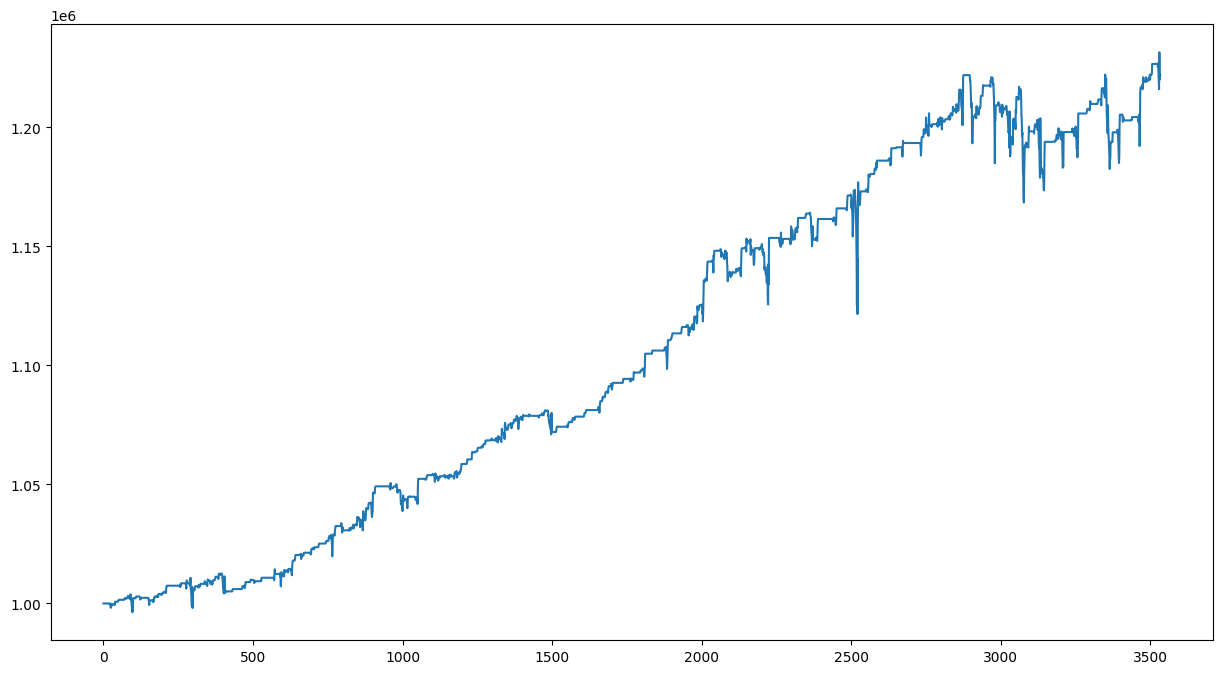

In [8]:
# 종가가 5일 최저가 & 종가가 20일 이평 아래

# 파라미터 설정
holding_cash = 1_000_000 # 보유 현금
position = 0 # 현재 보유 포지션
avg_price = 0 # 평단가

# 일별 총 포트폴리오 가치
daily_total_value = []

holding_time_passed = 0 # 마지막 매수 후 경과 일수


# for 문으로 하루씩 백테스팅 진행
for idx,data in d.iterrows():
    daily_total_value.append(0)

    if (data['close'] < data['20d_mean']) and (data['close'] == data['5d_min']):
        if holding_cash > 1*data['close']:
            position += 1
            holding_cash -= 1 * data['close']
            avg_price = data['close']
            holding_time_passed = 0

    # 마지막 매수 3일 후 매도
    if position > 0 and holding_time_passed == 3:
        holding_cash += position * data['close']
        position = 0
        avg_price = 0

    # 오늘의 마무리
    if position > 0:
        holding_time_passed += 1
    
    daily_total_value[-1] = holding_cash + position * data['close']

plt.figure(figsize=(15,8))
plt.plot(daily_total_value)

return1 = daily_total_value.copy()

## (2) 슬리피지가 들어간 백테스팅

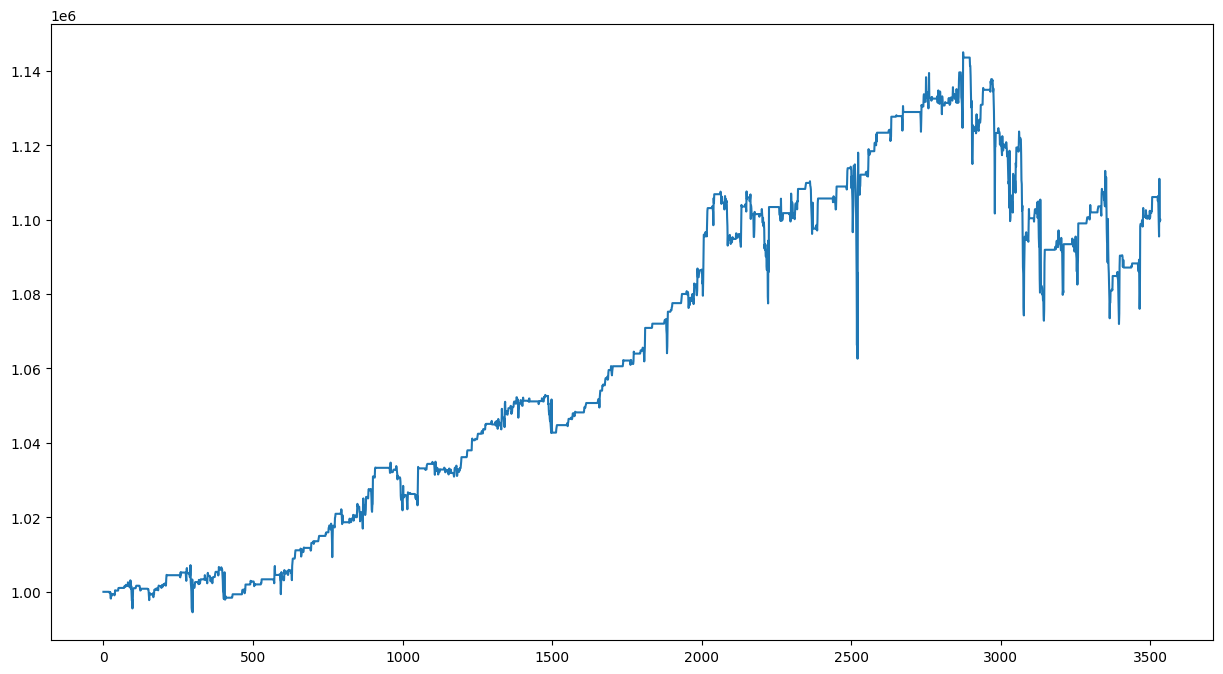

In [10]:
################ 백테스팅 파라미터 ################
holding_cash = 1_000_000 # 보유 현금
position = 0 # 현재 보유 포지션
avg_price = 0 # 평단가
slippage = 0.004 # 슬리피지
daily_total_value = [] # 일별 총 포트폴리오 가치
################ 백테스팅 파라미터 ################

################ 전략 파라미터 ################
holding_time_passed = 0 # 마지막 매수 후 경과 일수
################ 전략 파라미터 ################

# for 문으로 하루씩 백테스팅 진행
for idx,data in d.iterrows():
    daily_total_value.append(0)

    if (data['close'] < data['20d_mean']) and (data['close'] == data['5d_min']):
        if holding_cash > 1*data['close']:
            position += 1
            holding_cash -= 1 * data['close']
            avg_price = data['close']
            holding_time_passed = 0

    # 마지막 매수 3일 후 매도
    if position > 0 and holding_time_passed == 3:
        holding_cash += position * data['close'] * (1-slippage)
        position = 0
        avg_price = 0

    # 오늘의 마무리
    if position > 0:
        holding_time_passed += 1
    
    daily_total_value[-1] = holding_cash + position * data['close']

plt.figure(figsize=(15,8))
plt.plot(daily_total_value)

return2 = daily_total_value.copy()

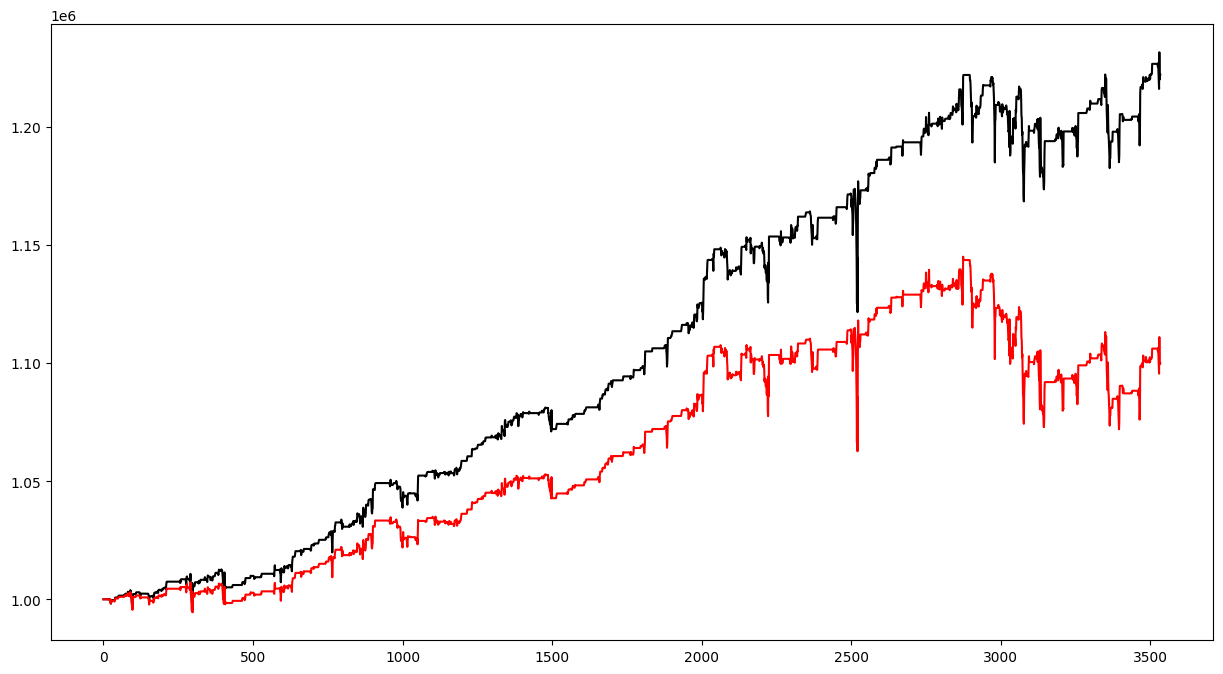

In [12]:
plt.figure(figsize=(15,8))
plt.plot(return1,c='k') # 검정색
plt.plot(return2,c='r') # 빨간색